All Models -> LR, SVM, KNN, DT, Stacking, Bagging 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import pickle

In [21]:
import os
rd_path = '\datasets\Dataset_Healthy_Older_People'
op_filepath = '\datasets\Dataset_Healthy_Older_People\composite_dataset.csv'
#Time : Time in seconds starting from 0 rounded to the closest 0.025s
#FrontalAxis : Acceleration reading in G for frontal axis
#VerticalAxis : Acceleration reading in G for vertical axis
#LateralAxis : Acceleration reading in G for lateral axis
#ReadingSensorAntennaID : RSAID
#RSSI : Received signal strength indicator (RSSI) 
#Phase
#Frequency
#Gender : Male -0, Female -1, Other - 2 # Newly addded 
#Activity : Label of activity, 1: sit on bed, 2: sit on chair, 3: lying, 4: ambulating

def generateComposite(rd_path,op_filepath):
    try:
        
        cols_lst = ['Time','FrontalAxis','VerticalAxis','LateralAxis',
                                         'RSAID','RSSI','Phase','Frequency','Gender','Activity']
        compo_df = pd.DataFrame(columns=cols_lst)
        f_path = os.path.abspath(os.getcwd() + rd_path)
        op_filepath = os.path.abspath(os.getcwd() + op_filepath)
        # print(f_path)
        # print(op_filepath)
        if(os.path.exists(f_path)):
            for e in os.listdir(f_path):
                subdict = os.path.abspath(f_path +'\\'+ e)
                if(os.path.isdir(subdict)):
                     for file in os.listdir(subdict):
                        #print(file)
                        df = pd.DataFrame()
                        if('README' in file):
                            continue
                            
                        if file[-1] is not None:
                            if file[-1] == "M": 
                                gender = 0
                            elif file[-1] == "F":
                                gender = 1
                            else:
                                gender = 2
                        else:
                            gender = None
                            
                        df = pd.read_csv(subdict + '\\'+ file,header=None)
                        df_len = len(df.columns)
                        df[df_len] = df[df_len - 1] 
                        df[df_len -1 ] = gender
                        df.columns = cols_lst 
                        #print(df.head(2))
                        compo_df = pd.concat([compo_df,df],ignore_index =True)
                


        #print(compo_df)
        if os.path.exists(op_filepath):
            os.remove(op_filepath)
            
        compo_df.to_csv(op_filepath)
        return compo_df,op_filepath
    except Exception as e:
        print(e)
    
data,csv_file = generateComposite(rd_path,op_filepath)

In [22]:
data.head()

,Time,FrontalAxis,VerticalAxis,LateralAxis,RSAID,RSSI,Phase,Frequency,Gender,Activity
0,0.00,0.27203,1.00820,-0.082102,1,-63.5,2.4252,924.25,0,1
1,0.50,0.27203,1.00820,-0.082102,1,-63.0,4.7369,921.75,0,1
2,1.50,0.44791,0.91636,-0.013684,1,-63.5,3.0311,923.75,0,1
3,1.75,0.44791,0.91636,-0.013684,1,-63.0,2.0371,921.25,0,1
4,2.50,0.34238,0.96229,-0.059296,1,-63.5,5.8920,920.25,0,1


In [77]:
pf = ProfileReport(df)
pf.to_widgets()

In [78]:
pf.to_file('HealthyOlderPeople_report.html')

In [ ]:
# data set is imbalance bcoz 60% up data belongs to single class i.e. 3 
# no missing data
# vertical axis accelaration highly correlated to frontal axis accelaration
# phase and frequency has very low correlation with label column Activity (will exclude from feature list and compare accuracy )
# Time has lot of zero values in some features (may be due to data capturing device error)
# RSAID slightly correlated with RSSI ignoring for now

In [23]:
data.columns

Index(['Time', 'FrontalAxis', 'VerticalAxis', 'LateralAxis', 'RSAID', 'RSSI',
       'Phase', 'Frequency', 'Gender', 'Activity'],
      dtype='object')

In [24]:
data.dtypes

Time            float64
FrontalAxis     float64
VerticalAxis    float64
LateralAxis     float64
RSAID            object
RSSI            float64
Phase           float64
Frequency       float64
Gender           object
Activity         object
dtype: object

In [25]:
# changing data type of RSAID, Gender and Activity 
data.RSAID = data.RSAID.astype('int')
data.Gender = data.Gender.astype('int')
data.Activity = data.Activity.astype('int')
data.dtypes

Time            float64
FrontalAxis     float64
VerticalAxis    float64
LateralAxis     float64
RSAID             int32
RSSI            float64
Phase           float64
Frequency       float64
Gender            int32
Activity          int32
dtype: object

In [26]:
data.FrontalAxis [data.FrontalAxis < 0].count()

1176

In [27]:
data.VerticalAxis [data.FrontalAxis < 0].count()
#FrontalAxis and VerticalAxis has negative values might be w.r.t direction 
# so to remove multicollinearity not merging them into single magnitute like sq. root(x2+y2) 

1176

In [28]:
for cols in data.columns:
    print(' {} zero count - {}'.format(cols,data[cols][data[cols] == 0].count()))

 Time zero count - 87
 FrontalAxis zero count - 0
 VerticalAxis zero count - 0
 LateralAxis zero count - 0
 RSAID zero count - 0
 RSSI zero count - 0
 Phase zero count - 1
 Frequency zero count - 0
 Gender zero count - 31300
 Activity zero count - 0


In [29]:
# replacing zeors of Time with avg value
data['Time'] = data['Time'].replace(0, data.Time.mean())
data['Time'][data['Time'] == 0].count()

0

<AxesSubplot:>

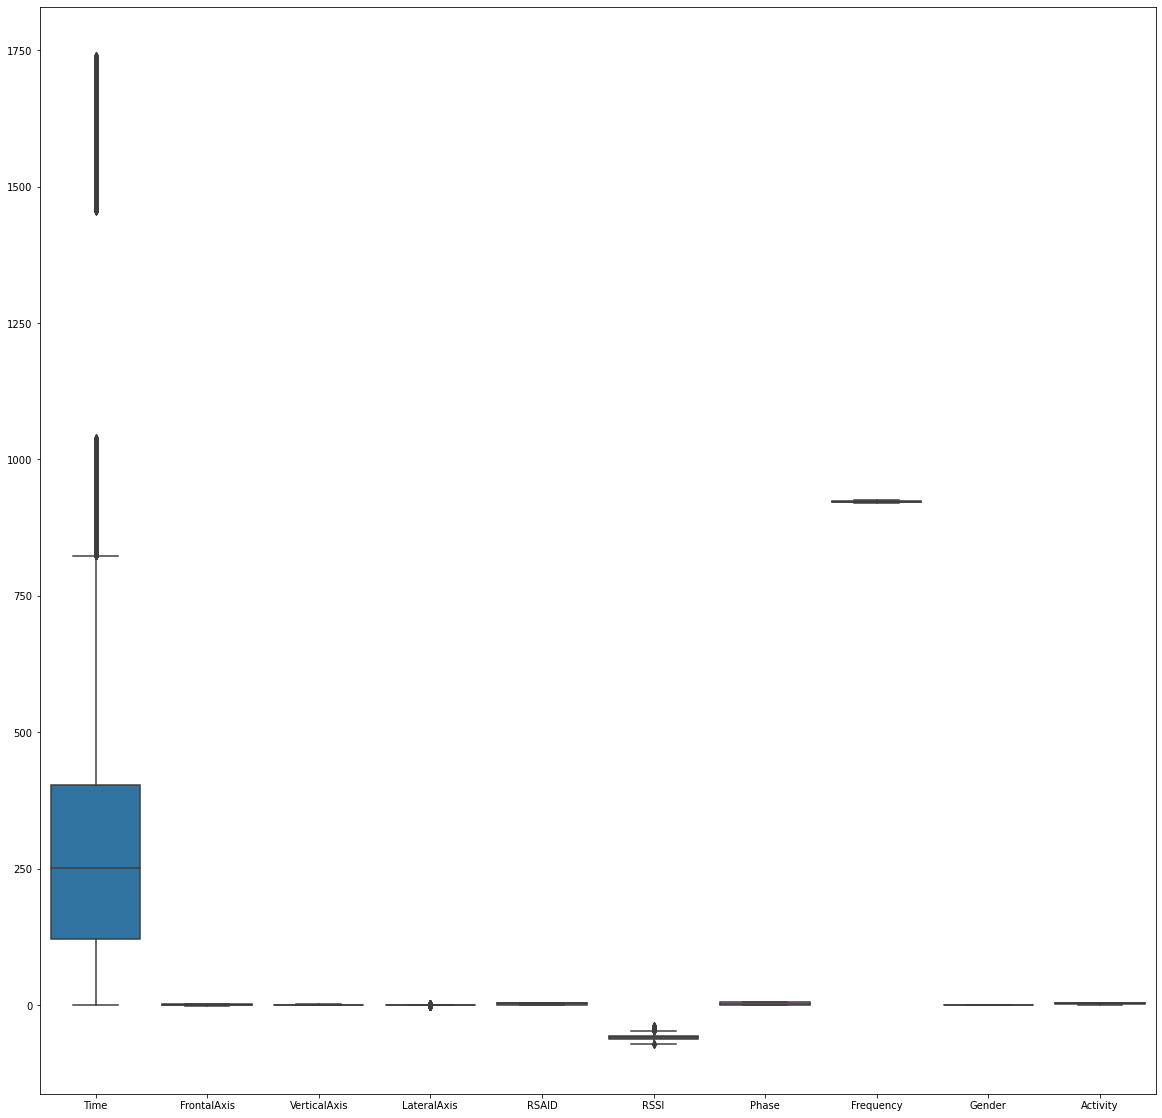

In [30]:
fig, ax = plt.subplots(figsize = (20,20))
sns.boxplot(data = data , ax =ax)
# Time has many outlier it is right skewed 

In [31]:
y = data['Activity']
x = data.drop(columns=['Activity'])
# will again try by removing ['Phase', 'Frequency']
#x = data.drop(columns=['Activity','Phase', 'Frequency']) 

In [32]:
scalar = StandardScaler()
x_scaled = scalar.fit_transform(x)

In [33]:
pfnew = ProfileReport(pd.DataFrame(x_scaled))
pfnew.to_widgets()

In [35]:
# To remove multicollinearity using Variance Inflation Factor VIF

vif_df = pd.DataFrame()
vif_df['vif'] = [variance_inflation_factor(x_scaled,i) for i in range(x_scaled.shape[1])]
vif_df['feature'] = x.columns
vif_df

# VIF value for any feature column not more than 10 so seems no issue 

,vif,feature
0,1.238518,Time
1,4.418484,FrontalAxis
2,4.169607,VerticalAxis
3,2.414793,LateralAxis
4,1.166242,RSAID
5,1.115588,RSSI
6,1.008793,Phase
7,1.048439,Frequency
8,1.265441,Gender


In [36]:
x_train,x_test,y_train,y_test = train_test_split(x_scaled,y,test_size=0.25,random_state=40) # Randomly splitting data in train and test data with 25%,75% ratio

In [37]:
# For Logistic Regression
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV, ElasticNet,ElasticNetCV,LogisticRegression

In [147]:
logr = LogisticRegression(random_state=20,multi_class='ovr',verbose=1) # using ovr as it is a multiclass problem

# GridSearchCV gave best params -> {'C': 0.5, 'penalty': 'none', 'solver': 'newton-cg'}
best_logr = LogisticRegression(C=0.5,penalty='none',solver='newton-cg',random_state=20,multi_class='ovr',verbose=1) # after hyper parameter tunning 

In [112]:
x_train

array([[ 0.03635153, -1.32477734,  1.58219543, ...,  1.19483579,
        -0.25045568,  0.84507712],
       [ 0.06829869,  0.96467046, -0.28119021, ..., -0.56321815,
        -0.54823744,  0.84507712],
       [-0.13741461,  0.47206361, -1.18552277, ...,  0.90243016,
         1.53623491, -1.18332396],
       ...,
       [-1.08988313, -0.74516717, -0.25379415, ...,  0.88625414,
        -0.54823744,  0.84507712],
       [-0.68964969,  0.21122668,  1.06157479, ..., -1.28794055,
        -1.14380097, -1.18332396],
       [-0.98689045, -0.94801837,  1.50003111, ...,  1.35018058,
         0.04732609, -1.18332396]])

In [113]:
y_train

40365    1
36352    3
2521     3
60763    1
24061    3
        ..
11532    1
54578    3
56760    3
30727    2
11590    1
Name: Activity, Length: 56346, dtype: int32

In [148]:
logr.fit(x_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished


LogisticRegression(multi_class='ovr', random_state=20, verbose=1)

In [149]:
best_logr.fit(x_train,y_train)

D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished


LogisticRegression(C=0.5, multi_class='ovr', penalty='none', random_state=20,
                   solver='newton-cg', verbose=1)

In [151]:
y_pred = logr.predict(x_test)
y_pred

array([3, 3, 3, ..., 1, 1, 1])

In [152]:
y_prob_pred = logr.predict_proba(x_test)
y_prob_pred

array([[4.93263697e-03, 3.05753991e-02, 9.64085318e-01, 4.06646383e-04],
       [5.31440742e-03, 9.18461211e-04, 9.93761556e-01, 5.57560026e-06],
       [1.14609362e-03, 5.20872326e-03, 9.93469026e-01, 1.76157231e-04],
       ...,
       [6.48162996e-01, 1.03230519e-03, 5.66360557e-04, 3.50238338e-01],
       [7.10903342e-01, 2.87575014e-01, 7.33168795e-06, 1.51431177e-03],
       [5.68445441e-01, 3.36812493e-01, 9.37693843e-07, 9.47411282e-02]])

In [159]:
yb_pred = best_logr.predict(x_test)
yb_prob_pred = best_logr.predict_proba(x_test)

In [126]:
print('Actual -> ',y_test.iloc[213])
print('Predicted -> ',logr.predict([x_test[213]]))

Actual ->  3
Predicted ->  [3]


In [118]:
matrix = confusion_matrix(y_test,y_pred)
matrix

array([[ 3943,    94,    99,     1],
       [  856,   365,     0,     6],
       [    2,     3, 12827,     0],
       [  348,    31,     2,   205]], dtype=int64)

In [155]:
confusion_matrix(y_test,yb_pred)

array([[ 3945,    96,    95,     1],
       [  855,   366,     0,     6],
       [    2,     3, 12827,     0],
       [  346,    31,     2,   207]], dtype=int64)

In [119]:
from sklearn import metrics
# Classification accuracy is a metric that summarizes the performance of a classification model 
# as the number of correct predictions divided by the total number of predictions.
# this is not correct metrics for imbalnced data set
# here in our case we have imbalanced data set
# so will consider other factors (like precision, recall) based on confusion matrix   
print(metrics.classification_report(y_test,y_pred,digits=3))


              precision    recall  f1-score   support

           1      0.766     0.953     0.849      4137
           2      0.740     0.297     0.424      1227
           3      0.992     1.000     0.996     12832
           4      0.967     0.350     0.514       586

    accuracy                          0.923     18782
   macro avg      0.866     0.650     0.696     18782
weighted avg      0.925     0.923     0.911     18782



In [156]:
print(metrics.classification_report(y_test,yb_pred,digits=3))
#slight increase in recall and f1-score

              precision    recall  f1-score   support

           1      0.766     0.954     0.850      4137
           2      0.738     0.298     0.425      1227
           3      0.992     1.000     0.996     12832
           4      0.967     0.353     0.517       586

    accuracy                          0.923     18782
   macro avg      0.866     0.651     0.697     18782
weighted avg      0.925     0.923     0.912     18782



In [ ]:
#Precision => TP/(TP+FP)
#Recall => TP/(TP+FN)

# Here false positive and false positive both matters so will use F beta
# F beta = ((1+beta^2)*(Precision*Recall))/(beta^2*Precision+Recall)
# if both FP and FN have equal impact will keep beta = 1
# if FN have high impact will increase beta = 2
# if FP have high impact will reduce beta = 0.5

#i.e
#F0.5-Measure (beta=0.5): More weight on precision, less weight on recall.
#It has the effect of raising the importance of precision and lowering the importance of recall

#F1-Measure (beta=1.0): Balance the weight on precision and recall.

#F2-Measure (beta=2.0): Less weight on precision, more weight on recall
#It has the effect of lowering the importance of precision and increase the importance of recall.

In [134]:
# in lets give equal importance to both precision and recall hence lets keep beta =1
from sklearn.metrics import fbeta_score
print(fbeta_score(y_test, y_pred, average='macro', beta=1.0))
print(fbeta_score(y_test, y_pred, average='micro', beta=1.0))
print(fbeta_score(y_test, y_pred, average='weighted', beta=1.0))
print(fbeta_score(y_test, y_pred, average=None, beta=1.0))

0.6958308917782587
0.9232243637525289
0.911208802105794
[0.84923541 0.4244186  0.99588509 0.51378446]


In [157]:
print(fbeta_score(y_test, yb_pred, average='macro', beta=1.0))
print(fbeta_score(y_test, yb_pred, average='micro', beta=1.0))
print(fbeta_score(y_test, yb_pred, average='weighted', beta=1.0))
print(fbeta_score(y_test, yb_pred, average=None, beta=1.0)) 
# not much difference 

0.697034456513509
0.9234905760834842
0.9115729864420307
[0.84975767 0.42484039 0.99603976 0.5175    ]


In [128]:
auc = roc_auc_score(y_test,y_prob_pred,multi_class='ovr')
auc #predict_proba for multiclass label

0.957599941432368

In [160]:
auc_b = roc_auc_score(y_test,yb_prob_pred,multi_class='ovr')
auc_b #predict_proba for multiclass label

0.9576163763086679

In [142]:
# Using Grid search cv to find best params of LogisticRegression 
from sklearn.model_selection import GridSearchCV
lr_params = {
    'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C' : [0.5,1.0,1.5], # to control regularization small value means strong regularization
    # other params mostly depends on solver and penalty combo so not adding them for now   
}

grid_lr = GridSearchCV(logr,param_grid=lr_params,verbose=3)

In [143]:
grid_lr.fit(x_train,y_train)
grid_lr.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] C=0.5, penalty=l1, solver=newton-cg .............................
[CV] ... C=0.5, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.5, penalty=l1, solver=newton-cg .............................
[CV] ... C=0.5, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.5, penalty=l1, solver=newton-cg .............................
[CV] ... C=0.5, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.5, penalty=l1, solver=newton-cg .............................
[CV] ... C=0.5, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.5, penalty=l1, solver=newton-cg .............................
[CV] ... C=0.5, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.5, penalty=l1, solver=lbfgs .................................
[CV] ....... C=0.5, penalty=l1, solver=lbfgs, score=nan, total=   0.0s
[CV] C=0.5, penalty=l1, solver=lbfgs .................................
[CV] ....... C=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
[Parallel(n_jobs=1)]: Done   1 o

[CV] . C=0.5, penalty=l1, solver=liblinear, score=0.924, total=   0.8s
[CV] C=0.5, penalty=l1, solver=liblinear .............................
[LibLinear][CV] . C=0.5, penalty=l1, solver=liblinear, score=0.924, total=   0.8s
[CV] C=0.5, penalty=l1, solver=liblinear .............................
[LibLinear][CV] . C=0.5, penalty=l1, solver=liblinear, score=0.925, total=   0.8s
[CV] C=0.5, penalty=l1, solver=liblinear .............................
[LibLinear][CV] . C=0.5, penalty=l1, solver=liblinear, score=0.921, total=   0.8s
[CV] C=0.5, penalty=l1, solver=liblinear .............................
[LibLinear][CV] . C=0.5, penalty=l1, solver=liblinear, score=0.924, total=   0.8s
[CV] C=0.5, penalty=l1, solver=sag ...................................
[CV] ......... C=0.5, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.5, penalty=l1, solver=sag ...................................
[CV] ......... C=0.5, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=0.5, penalty=l1, solver=sa

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



convergence after 14 epochs took 0 seconds
convergence after 16 epochs took 0 seconds
convergence after 13 epochs took 0 seconds
[CV] ...... C=0.5, penalty=l1, solver=saga, score=0.924, total=   0.5s
[CV] C=0.5, penalty=l1, solver=saga ..................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 19 epochs took 0 seconds
convergence after 14 epochs took 1 seconds
[CV] ...... C=0.5, penalty=l1, solver=saga, score=0.924, total=   0.6s
[CV] C=0.5, penalty=l1, solver=saga ..................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 15 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
[CV] ...... C=0.5, penalty=l1, solver=saga, score=0.925, total=   0.5s
[CV] C=0.5, penalty=l1, solver=saga ..................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 0 seconds
convergence after 13 epochs took 0 seconds
convergence after 15 epochs took 0 seconds
convergence after 14 epochs took 1 seconds
[CV] ...... C=0.5, penalty=l1, solver=saga, score=0.921, total=   0.5s
[CV] C=0.5, penalty=l1, solver=saga ..................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 0 seconds
convergence after 13 epochs took 0 seconds
convergence after 20 epochs took 0 seconds
convergence after 15 epochs took 0 seconds
[CV] ...... C=0.5, penalty=l1, solver=saga, score=0.924, total=   0.5s
[CV] C=0.5, penalty=l2, solver=newton-cg .............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . C=0.5, penalty=l2, solver=newton-cg, score=0.924, total=   0.5s
[CV] C=0.5, penalty=l2, solver=newton-cg .............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . C=0.5, penalty=l2, solver=newton-cg, score=0.924, total=   0.5s
[CV] C=0.5, penalty=l2, solver=newton-cg .............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . C=0.5, penalty=l2, solver=newton-cg, score=0.924, total=   0.5s
[CV] C=0.5, penalty=l2, solver=newton-cg .............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . C=0.5, penalty=l2, solver=newton-cg, score=0.921, total=   0.5s
[CV] C=0.5, penalty=l2, solver=newton-cg .............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . C=0.5, penalty=l2, solver=newton-cg, score=0.923, total=   0.5s
[CV] C=0.5, penalty=l2, solver=lbfgs .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... C=0.5, penalty=l2, solver=lbfgs, score=0.924, total=   0.2s
[CV] C=0.5, penalty=l2, solver=lbfgs .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished


[CV] ..... C=0.5, penalty=l2, solver=lbfgs, score=0.924, total=   0.3s
[CV] C=0.5, penalty=l2, solver=lbfgs .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished


[CV] ..... C=0.5, penalty=l2, solver=lbfgs, score=0.924, total=   0.2s
[CV] C=0.5, penalty=l2, solver=lbfgs .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... C=0.5, penalty=l2, solver=lbfgs, score=0.921, total=   0.2s
[CV] C=0.5, penalty=l2, solver=lbfgs .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished


[CV] ..... C=0.5, penalty=l2, solver=lbfgs, score=0.923, total=   0.2s
[CV] C=0.5, penalty=l2, solver=liblinear .............................
[LibLinear][CV] . C=0.5, penalty=l2, solver=liblinear, score=0.924, total=   0.4s
[CV] C=0.5, penalty=l2, solver=liblinear .............................
[LibLinear][CV] . C=0.5, penalty=l2, solver=liblinear, score=0.923, total=   0.4s
[CV] C=0.5, penalty=l2, solver=liblinear .............................
[LibLinear][CV] . C=0.5, penalty=l2, solver=liblinear, score=0.925, total=   0.4s
[CV] C=0.5, penalty=l2, solver=liblinear .............................
[LibLinear][CV] . C=0.5, penalty=l2, solver=liblinear, score=0.921, total=   0.4s
[CV] C=0.5, penalty=l2, solver=liblinear .............................
[LibLinear][CV] . C=0.5, penalty=l2, solver=liblinear, score=0.923, total=   0.3s
[CV] C=0.5, penalty=l2, solver=sag ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 24 epochs took 0 seconds
convergence after 20 epochs took 0 seconds
convergence after 19 epochs took 0 seconds
convergence after 20 epochs took 0 seconds
[CV] ....... C=0.5, penalty=l2, solver=sag, score=0.924, total=   0.7s
[CV] C=0.5, penalty=l2, solver=sag ...................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 0 seconds
convergence after 19 epochs took 1 seconds
convergence after 18 epochs took 0 seconds
convergence after 22 epochs took 0 seconds
[CV] ....... C=0.5, penalty=l2, solver=sag, score=0.924, total=   0.6s
[CV] C=0.5, penalty=l2, solver=sag ...................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 0 seconds
convergence after 21 epochs took 0 seconds
convergence after 17 epochs took 0 seconds
convergence after 23 epochs took 1 seconds
[CV] ....... C=0.5, penalty=l2, solver=sag, score=0.924, total=   0.6s
[CV] C=0.5, penalty=l2, solver=sag ...................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 20 epochs took 0 seconds
convergence after 20 epochs took 0 seconds
convergence after 17 epochs took 0 seconds
convergence after 22 epochs took 0 seconds
[CV] ....... C=0.5, penalty=l2, solver=sag, score=0.921, total=   0.7s
[CV] C=0.5, penalty=l2, solver=sag ...................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 0 seconds
convergence after 21 epochs took 1 seconds
convergence after 17 epochs took 0 seconds
convergence after 21 epochs took 0 seconds
[CV] ....... C=0.5, penalty=l2, solver=sag, score=0.923, total=   0.6s
[CV] C=0.5, penalty=l2, solver=saga ..................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 0 seconds
convergence after 13 epochs took 0 seconds
convergence after 15 epochs took 0 seconds
convergence after 13 epochs took 0 seconds
[CV] ...... C=0.5, penalty=l2, solver=saga, score=0.924, total=   0.4s
[CV] C=0.5, penalty=l2, solver=saga ..................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 15 epochs took 1 seconds
convergence after 14 epochs took 0 seconds
[CV] ...... C=0.5, penalty=l2, solver=saga, score=0.924, total=   0.5s
[CV] C=0.5, penalty=l2, solver=saga ..................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 15 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
[CV] ...... C=0.5, penalty=l2, solver=saga, score=0.924, total=   0.5s
[CV] C=0.5, penalty=l2, solver=saga ..................................
convergence after 13 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 0 seconds
convergence after 15 epochs took 1 seconds
convergence after 14 epochs took 0 seconds
[CV] ...... C=0.5, penalty=l2, solver=saga, score=0.921, total=   0.4s
[CV] C=0.5, penalty=l2, solver=saga ..................................
convergence after 13 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 0 seconds
convergence after 15 epochs took 0 seconds
convergence after 14 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s finished
D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
D:\Anaconda3\lib\site-packages\skle

[CV] ...... C=0.5, penalty=l2, solver=saga, score=0.923, total=   0.5s
[CV] C=0.5, penalty=elasticnet, solver=newton-cg .....................
[CV]  C=0.5, penalty=elasticnet, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.5, penalty=elasticnet, solver=newton-cg .....................
[CV]  C=0.5, penalty=elasticnet, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.5, penalty=elasticnet, solver=newton-cg .....................
[CV]  C=0.5, penalty=elasticnet, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.5, penalty=elasticnet, solver=newton-cg .....................
[CV]  C=0.5, penalty=elasticnet, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.5, penalty=elasticnet, solver=newton-cg .....................
[CV]  C=0.5, penalty=elasticnet, solver=newton-cg, score=nan, total=   0.0s
[CV] C=0.5, penalty=elasticnet, solver=lbfgs .........................
[CV]  C=0.5, penalty=elasticnet, solver=lbfgs, score=nan, total=   0.0s
[CV] C=0.5, penalty=elasticnet, solver=lbfgs ......

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.5, penalty=none, solver=newton-cg, score=0.924, total=   0.5s
[CV] C=0.5, penalty=none, solver=newton-cg ...........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.5, penalty=none, solver=newton-cg, score=0.924, total=   0.6s
[CV] C=0.5, penalty=none, solver=newton-cg ...........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.5, penalty=none, solver=newton-cg, score=0.925, total=   0.5s
[CV] C=0.5, penalty=none, solver=newton-cg ...........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.5, penalty=none, solver=newton-cg, score=0.921, total=   0.6s
[CV] C=0.5, penalty=none, solver=newton-cg ...........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished


[CV]  C=0.5, penalty=none, solver=newton-cg, score=0.924, total=   0.5s
[CV] C=0.5, penalty=none, solver=lbfgs ...............................


D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished


[CV] ... C=0.5, penalty=none, solver=lbfgs, score=0.924, total=   0.2s
[CV] C=0.5, penalty=none, solver=lbfgs ...............................


D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... C=0.5, penalty=none, solver=lbfgs, score=0.924, total=   0.2s
[CV] C=0.5, penalty=none, solver=lbfgs ...............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... C=0.5, penalty=none, solver=lbfgs, score=0.925, total=   0.2s
[CV] C=0.5, penalty=none, solver=lbfgs ...............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... C=0.5, penalty=none, solver=lbfgs, score=0.921, total=   0.2s
[CV] C=0.5, penalty=none, solver=lbfgs ...............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 453, in _check_solver
    raise ValueError(
ValueError: penalty='none' is not supported for the liblinear solver

  warnings.warn("Estimator fit failed. The score on this train-test"
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will

[CV] ... C=0.5, penalty=none, solver=lbfgs, score=0.924, total=   0.2s
[CV] C=0.5, penalty=none, solver=liblinear ...........................
[CV] . C=0.5, penalty=none, solver=liblinear, score=nan, total=   0.0s
[CV] C=0.5, penalty=none, solver=liblinear ...........................
[CV] . C=0.5, penalty=none, solver=liblinear, score=nan, total=   0.0s
[CV] C=0.5, penalty=none, solver=liblinear ...........................
[CV] . C=0.5, penalty=none, solver=liblinear, score=nan, total=   0.0s
[CV] C=0.5, penalty=none, solver=liblinear ...........................
[CV] . C=0.5, penalty=none, solver=liblinear, score=nan, total=   0.0s
[CV] C=0.5, penalty=none, solver=liblinear ...........................
[CV] . C=0.5, penalty=none, solver=liblinear, score=nan, total=   0.0s
[CV] C=0.5, penalty=none, solver=sag .................................
convergence after 25 epochs took 0 seconds
convergence after 21 epochs took 0 seconds
convergence after 19 epochs took 0 seconds
convergence after 2

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 25 epochs took 0 seconds
convergence after 20 epochs took 0 seconds
convergence after 20 epochs took 0 seconds
convergence after 24 epochs took 0 seconds
[CV] ..... C=0.5, penalty=none, solver=sag, score=0.924, total=   0.6s
[CV] C=0.5, penalty=none, solver=sag .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 25 epochs took 0 seconds
convergence after 21 epochs took 1 seconds
convergence after 20 epochs took 0 seconds
convergence after 26 epochs took 0 seconds
[CV] ..... C=0.5, penalty=none, solver=sag, score=0.925, total=   0.7s
[CV] C=0.5, penalty=none, solver=sag .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 0 seconds
convergence after 23 epochs took 0 seconds
convergence after 19 epochs took 0 seconds
convergence after 24 epochs took 0 seconds
[CV] ..... C=0.5, penalty=none, solver=sag, score=0.921, total=   0.6s
[CV] C=0.5, penalty=none, solver=sag .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 26 epochs took 1 seconds
convergence after 21 epochs took 0 seconds
convergence after 20 epochs took 0 seconds
convergence after 23 epochs took 0 seconds
[CV] ..... C=0.5, penalty=none, solver=sag, score=0.924, total=   0.6s
[CV] C=0.5, penalty=none, solver=saga ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 18 epochs took 0 seconds
convergence after 13 epochs took 1 seconds
[CV] .... C=0.5, penalty=none, solver=saga, score=0.924, total=   0.5s
[CV] C=0.5, penalty=none, solver=saga ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
[CV] .... C=0.5, penalty=none, solver=saga, score=0.924, total=   0.5s
[CV] C=0.5, penalty=none, solver=saga ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 17 epochs took 0 seconds
convergence after 15 epochs took 1 seconds
[CV] .... C=0.5, penalty=none, solver=saga, score=0.925, total=   0.5s
[CV] C=0.5, penalty=none, solver=saga ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 0 seconds
convergence after 13 epochs took 0 seconds
convergence after 22 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
[CV] .... C=0.5, penalty=none, solver=saga, score=0.921, total=   0.5s
[CV] C=0.5, penalty=none, solver=saga ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 0 seconds
convergence after 13 epochs took 0 seconds
convergence after 26 epochs took 0 seconds
convergence after 15 epochs took 1 seconds
[CV] .... C=0.5, penalty=none, solver=saga, score=0.924, total=   0.5s
[CV] C=1.0, penalty=l1, solver=newton-cg .............................
[CV] ... C=1.0, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1.0, penalty=l1, solver=newton-cg .............................
[CV] ... C=1.0, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1.0, penalty=l1, solver=newton-cg .............................
[CV] ... C=1.0, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1.0, penalty=l1, solver=newton-cg .............................
[CV] ... C=1.0, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1.0, penalty=l1, solver=newton-cg .............................
[CV] ... C=1.0, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1.0, penalty=l1, solver=lbfgs ..........

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
D:\Anaconda3\lib\site-packages\sklearn\mode

[CV] . C=1.0, penalty=l1, solver=liblinear, score=0.924, total=   0.8s
[CV] C=1.0, penalty=l1, solver=liblinear .............................
[LibLinear][CV] . C=1.0, penalty=l1, solver=liblinear, score=0.924, total=   0.8s
[CV] C=1.0, penalty=l1, solver=liblinear .............................
[LibLinear][CV] . C=1.0, penalty=l1, solver=liblinear, score=0.925, total=   0.8s
[CV] C=1.0, penalty=l1, solver=liblinear .............................
[LibLinear][CV] . C=1.0, penalty=l1, solver=liblinear, score=0.921, total=   0.8s
[CV] C=1.0, penalty=l1, solver=liblinear .............................
[LibLinear][CV] . C=1.0, penalty=l1, solver=liblinear, score=0.924, total=   0.8s
[CV] C=1.0, penalty=l1, solver=sag ...................................
[CV] ......... C=1.0, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1.0, penalty=l1, solver=sag ...................................
[CV] ......... C=1.0, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1.0, penalty=l1, solver=sa

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 0 seconds
convergence after 11 epochs took 0 seconds
convergence after 13 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... C=1.0, penalty=l1, solver=saga, score=0.924, total=   0.5s
[CV] C=1.0, penalty=l1, solver=saga ..................................
convergence after 13 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 18 epochs took 0 seconds
convergence after 14 epochs took 1 seconds
[CV] ...... C=1.0, penalty=l1, solver=saga, score=0.924, total=   0.6s
[CV] C=1.0, penalty=l1, solver=saga ..................................
convergence after 14 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 0 seconds
convergence after 11 epochs took 0 seconds
convergence after 15 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... C=1.0, penalty=l1, solver=saga, score=0.925, total=   0.5s
[CV] C=1.0, penalty=l1, solver=saga ..................................
convergence after 13 epochs took 0 seconds
convergence after 13 epochs took 0 seconds
convergence after 19 epochs took 1 seconds
convergence after 14 epochs took 0 seconds
[CV] ...... C=1.0, penalty=l1, solver=saga, score=0.921, total=   0.5s
[CV] C=1.0, penalty=l1, solver=saga ..................................
convergence after 13 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 0 seconds
convergence after 23 epochs took 0 seconds
convergence after 15 epochs took 0 seconds
[CV] ...... C=1.0, penalty=l1, solver=saga, score=0.924, total=   0.6s
[CV] C=1.0, penalty=l2, solver=newton-cg .............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . C=1.0, penalty=l2, solver=newton-cg, score=0.924, total=   0.5s
[CV] C=1.0, penalty=l2, solver=newton-cg .............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . C=1.0, penalty=l2, solver=newton-cg, score=0.924, total=   0.5s
[CV] C=1.0, penalty=l2, solver=newton-cg .............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . C=1.0, penalty=l2, solver=newton-cg, score=0.925, total=   0.5s
[CV] C=1.0, penalty=l2, solver=newton-cg .............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . C=1.0, penalty=l2, solver=newton-cg, score=0.921, total=   0.5s
[CV] C=1.0, penalty=l2, solver=newton-cg .............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished


[CV] . C=1.0, penalty=l2, solver=newton-cg, score=0.923, total=   0.5s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... C=1.0, penalty=l2, solver=lbfgs, score=0.924, total=   0.2s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished


[CV] ..... C=1.0, penalty=l2, solver=lbfgs, score=0.924, total=   0.2s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished


[CV] ..... C=1.0, penalty=l2, solver=lbfgs, score=0.925, total=   0.2s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... C=1.0, penalty=l2, solver=lbfgs, score=0.921, total=   0.2s
[CV] C=1.0, penalty=l2, solver=lbfgs .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished


[CV] ..... C=1.0, penalty=l2, solver=lbfgs, score=0.923, total=   0.2s
[CV] C=1.0, penalty=l2, solver=liblinear .............................
[LibLinear][CV] . C=1.0, penalty=l2, solver=liblinear, score=0.924, total=   0.3s
[CV] C=1.0, penalty=l2, solver=liblinear .............................
[LibLinear][CV] . C=1.0, penalty=l2, solver=liblinear, score=0.924, total=   0.3s
[CV] C=1.0, penalty=l2, solver=liblinear .............................
[LibLinear][CV] . C=1.0, penalty=l2, solver=liblinear, score=0.925, total=   0.3s
[CV] C=1.0, penalty=l2, solver=liblinear .............................
[LibLinear][CV] . C=1.0, penalty=l2, solver=liblinear, score=0.921, total=   0.3s
[CV] C=1.0, penalty=l2, solver=liblinear .............................
[LibLinear][CV] . C=1.0, penalty=l2, solver=liblinear, score=0.923, total=   0.3s
[CV] C=1.0, penalty=l2, solver=sag ...................................
convergence after 24 epochs took 0 seconds

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



convergence after 21 epochs took 1 seconds
convergence after 21 epochs took 0 seconds
convergence after 21 epochs took 0 seconds
[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.924, total=   0.6s
[CV] C=1.0, penalty=l2, solver=sag ...................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 0 seconds
convergence after 20 epochs took 0 seconds
convergence after 19 epochs took 0 seconds
convergence after 23 epochs took 1 seconds
[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.924, total=   0.7s
[CV] C=1.0, penalty=l2, solver=sag ...................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 24 epochs took 0 seconds
convergence after 21 epochs took 0 seconds
convergence after 19 epochs took 0 seconds
convergence after 24 epochs took 0 seconds
[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.925, total=   0.7s

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[CV] C=1.0, penalty=l2, solver=sag ...................................
convergence after 22 epochs took 1 seconds
convergence after 20 epochs took 0 seconds
convergence after 19 epochs took 0 seconds
convergence after 23 epochs took 0 seconds
[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.921, total=   0.6s
[CV] C=1.0, penalty=l2, solver=sag ...................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 26 epochs took 0 seconds
convergence after 21 epochs took 0 seconds
convergence after 18 epochs took 0 seconds
convergence after 22 epochs took 1 seconds
[CV] ....... C=1.0, penalty=l2, solver=sag, score=0.923, total=   0.6s
[CV] C=1.0, penalty=l2, solver=saga ..................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 17 epochs took 0 seconds
convergence after 13 epochs took 0 seconds
[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.924, total=   0.6s
[CV] C=1.0, penalty=l2, solver=saga ..................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 17 epochs took 1 seconds
convergence after 14 epochs took 0 seconds
[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.924, total=   0.6s
[CV] C=1.0, penalty=l2, solver=saga ..................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 16 epochs took 0 seconds
convergence after 15 epochs took 0 seconds
[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.925, total=   0.5s
[CV] C=1.0, penalty=l2, solver=saga ..................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 0 seconds
convergence after 13 epochs took 0 seconds
convergence after 16 epochs took 1 seconds
convergence after 14 epochs took 0 seconds
[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.921, total=   0.5s
[CV] C=1.0, penalty=l2, solver=saga ..................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 0 seconds
convergence after 13 epochs took 0 seconds
convergence after 16 epochs took 0 seconds
convergence after 15 epochs took 0 seconds
[CV] ...... C=1.0, penalty=l2, solver=saga, score=0.923, total=   0.5s
[CV] C=1.0, penalty=elasticnet, solver=newton-cg .....................
[CV]  C=1.0, penalty=elasticnet, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1.0, penalty=elasticnet, solver=newton-cg .....................
[CV]  C=1.0, penalty=elasticnet, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1.0, penalty=elasticnet, solver=newton-cg .....................
[CV]  C=1.0, penalty=elasticnet, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1.0, penalty=elasticnet, solver=newton-cg .....................
[CV]  C=1.0, penalty=elasticnet, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1.0, penalty=elasticnet, solver=newton-cg .....................
[CV]  C=1.0, penalty=elasticnet, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1.0, penalty=el

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
D:\Anaconda3\lib\site-packages\skle

[CV]  C=1.0, penalty=elasticnet, solver=saga, score=nan, total=   0.0s
[CV] C=1.0, penalty=elasticnet, solver=saga ..........................
[CV]  C=1.0, penalty=elasticnet, solver=saga, score=nan, total=   0.0s
[CV] C=1.0, penalty=elasticnet, solver=saga ..........................
[CV]  C=1.0, penalty=elasticnet, solver=saga, score=nan, total=   0.0s
[CV] C=1.0, penalty=elasticnet, solver=saga ..........................
[CV]  C=1.0, penalty=elasticnet, solver=saga, score=nan, total=   0.0s
[CV] C=1.0, penalty=elasticnet, solver=saga ..........................
[CV]  C=1.0, penalty=elasticnet, solver=saga, score=nan, total=   0.0s
[CV] C=1.0, penalty=none, solver=newton-cg ...........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.0, penalty=none, solver=newton-cg, score=0.924, total=   0.6s
[CV] C=1.0, penalty=none, solver=newton-cg ...........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.0, penalty=none, solver=newton-cg, score=0.924, total=   0.6s
[CV] C=1.0, penalty=none, solver=newton-cg ...........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.0, penalty=none, solver=newton-cg, score=0.925, total=   0.5s
[CV] C=1.0, penalty=none, solver=newton-cg ...........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.0, penalty=none, solver=newton-cg, score=0.921, total=   0.6s
[CV] C=1.0, penalty=none, solver=newton-cg ...........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.0, penalty=none, solver=newton-cg, score=0.924, total=   0.5s
[CV] C=1.0, penalty=none, solver=lbfgs ...............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... C=1.0, penalty=none, solver=lbfgs, score=0.924, total=   0.2s
[CV] C=1.0, penalty=none, solver=lbfgs ...............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished


[CV] ... C=1.0, penalty=none, solver=lbfgs, score=0.924, total=   0.2s
[CV] C=1.0, penalty=none, solver=lbfgs ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... C=1.0, penalty=none, solver=lbfgs, score=0.925, total=   0.2s
[CV] C=1.0, penalty=none, solver=lbfgs ...............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... C=1.0, penalty=none, solver=lbfgs, score=0.921, total=   0.2s
[CV] C=1.0, penalty=none, solver=lbfgs ...............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 453, in _check_solver
    raise ValueError(
ValueError: penalty='none' is not supported for the liblinear solver

  warnings.warn("Estimator fit failed. The score on this train-test"
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... C=1.0, penalty=none, solver=lbfgs, score=0.924, total=   0.2s
[CV] C=1.0, penalty=none, solver=liblinear ...........................
[CV] . C=1.0, penalty=none, solver=liblinear, score=nan, total=   0.0s
[CV] C=1.0, penalty=none, solver=liblinear ...........................
[CV] . C=1.0, penalty=none, solver=liblinear, score=nan, total=   0.0s
[CV] C=1.0, penalty=none, solver=liblinear ...........................
[CV] . C=1.0, penalty=none, solver=liblinear, score=nan, total=   0.0s
[CV] C=1.0, penalty=none, solver=liblinear ...........................
[CV] . C=1.0, penalty=none, solver=liblinear, score=nan, total=   0.0s
[CV] C=1.0, penalty=none, solver=liblinear ...........................
[CV] . C=1.0, penalty=none, solver=liblinear, score=nan, total=   0.0s
[CV] C=1.0, penalty=none, solver=sag .................................
convergence after 25 epochs took 0 seconds
convergence after 21 epochs took 1 seconds
convergence after 19 epochs took 0 seconds
convergence after 2

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... C=1.0, penalty=none, solver=sag, score=0.924, total=   0.7s
[CV] C=1.0, penalty=none, solver=sag .................................
convergence after 25 epochs took 0 seconds
convergence after 20 epochs took 0 seconds
convergence after 20 epochs took 0 seconds
convergence after 24 epochs took 1 seconds
[CV] ..... C=1.0, penalty=none, solver=sag, score=0.924, total=   0.7s
[CV] C=1.0, penalty=none, solver=sag .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 25 epochs took 0 seconds
convergence after 21 epochs took 0 seconds
convergence after 20 epochs took 0 seconds
convergence after 26 epochs took 0 seconds
[CV] ..... C=1.0, penalty=none, solver=sag, score=0.925, total=   0.7s
[CV] C=1.0, penalty=none, solver=sag .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 0 seconds
convergence after 23 epochs took 1 seconds
convergence after 19 epochs took 0 seconds
convergence after 24 epochs took 0 seconds
[CV] ..... C=1.0, penalty=none, solver=sag, score=0.921, total=   0.7s
[CV] C=1.0, penalty=none, solver=sag .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 26 epochs took 0 seconds
convergence after 21 epochs took 0 seconds
convergence after 20 epochs took 0 seconds
convergence after 23 epochs took 1 seconds
[CV] ..... C=1.0, penalty=none, solver=sag, score=0.924, total=   0.7s
[CV] C=1.0, penalty=none, solver=saga ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 18 epochs took 0 seconds
convergence after 13 epochs took 0 seconds
[CV] .... C=1.0, penalty=none, solver=saga, score=0.924, total=   0.5s
[CV] C=1.0, penalty=none, solver=saga ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 14 epochs took 1 seconds
[CV] .... C=1.0, penalty=none, solver=saga, score=0.924, total=   0.5s
[CV] C=1.0, penalty=none, solver=saga ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 17 epochs took 0 seconds
convergence after 15 epochs took 0 seconds
[CV] .... C=1.0, penalty=none, solver=saga, score=0.925, total=   0.5s
[CV] C=1.0, penalty=none, solver=saga ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 0 seconds
convergence after 13 epochs took 0 seconds
convergence after 22 epochs took 1 seconds
convergence after 14 epochs took 0 seconds
[CV] .... C=1.0, penalty=none, solver=saga, score=0.921, total=   0.5s
[CV] C=1.0, penalty=none, solver=saga ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 0 seconds
convergence after 13 epochs took 0 seconds
convergence after 26 epochs took 0 seconds
convergence after 15 epochs took 0 seconds
[CV] .... C=1.0, penalty=none, solver=saga, score=0.924, total=   0.7s
[CV] C=1.5, penalty=l1, solver=newton-cg .............................
[CV] ... C=1.5, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1.5, penalty=l1, solver=newton-cg .............................
[CV] ... C=1.5, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1.5, penalty=l1, solver=newton-cg .............................
[CV] ... C=1.5, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1.5, penalty=l1, solver=newton-cg .............................
[CV] ... C=1.5, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1.5, penalty=l1, solver=newton-cg .............................
[CV] ... C=1.5, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1.5, penalty=l1, solver=lbfgs ..........

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
D:\Anaconda3\lib\site-packages\sklearn\mode

[CV] . C=1.5, penalty=l1, solver=liblinear, score=0.924, total=   0.9s
[CV] C=1.5, penalty=l1, solver=liblinear .............................
[LibLinear][CV] . C=1.5, penalty=l1, solver=liblinear, score=0.924, total=   0.8s
[CV] C=1.5, penalty=l1, solver=liblinear .............................
[LibLinear][CV] . C=1.5, penalty=l1, solver=liblinear, score=0.925, total=   0.8s
[CV] C=1.5, penalty=l1, solver=liblinear .............................
[LibLinear][CV] . C=1.5, penalty=l1, solver=liblinear, score=0.921, total=   0.8s
[CV] C=1.5, penalty=l1, solver=liblinear .............................
[LibLinear][CV] . C=1.5, penalty=l1, solver=liblinear, score=0.924, total=   0.8s
[CV] C=1.5, penalty=l1, solver=sag ...................................
[CV] ......... C=1.5, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1.5, penalty=l1, solver=sag ...................................
[CV] ......... C=1.5, penalty=l1, solver=sag, score=nan, total=   0.0s
[CV] C=1.5, penalty=l1, solver=sa

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 0 seconds
convergence after 12 epochs took 0 seconds
convergence after 13 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... C=1.5, penalty=l1, solver=saga, score=0.924, total=   0.5s
[CV] C=1.5, penalty=l1, solver=saga ..................................
convergence after 13 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 17 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
[CV] ...... C=1.5, penalty=l1, solver=saga, score=0.924, total=   0.5s
[CV] C=1.5, penalty=l1, solver=saga ..................................
convergence after 14 epochs took 1 seconds


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 0 seconds
convergence after 13 epochs took 0 seconds
convergence after 15 epochs took 0 seconds
[CV] ...... C=1.5, penalty=l1, solver=saga, score=0.925, total=   0.5s
[CV] C=1.5, penalty=l1, solver=saga ..................................
convergence after 13 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 0 seconds
convergence after 20 epochs took 0 seconds
convergence after 14 epochs took 1 seconds
[CV] ...... C=1.5, penalty=l1, solver=saga, score=0.921, total=   0.6s
[CV] C=1.5, penalty=l1, solver=saga ..................................
convergence after 13 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 0 seconds
convergence after 24 epochs took 0 seconds
convergence after 15 epochs took 0 seconds
[CV] ...... C=1.5, penalty=l1, solver=saga, score=0.924, total=   0.7s
[CV] C=1.5, penalty=l2, solver=newton-cg .............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . C=1.5, penalty=l2, solver=newton-cg, score=0.924, total=   0.5s
[CV] C=1.5, penalty=l2, solver=newton-cg .............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . C=1.5, penalty=l2, solver=newton-cg, score=0.924, total=   0.5s
[CV] C=1.5, penalty=l2, solver=newton-cg .............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . C=1.5, penalty=l2, solver=newton-cg, score=0.925, total=   0.5s
[CV] C=1.5, penalty=l2, solver=newton-cg .............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . C=1.5, penalty=l2, solver=newton-cg, score=0.921, total=   0.5s
[CV] C=1.5, penalty=l2, solver=newton-cg .............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished


[CV] . C=1.5, penalty=l2, solver=newton-cg, score=0.923, total=   0.5s
[CV] C=1.5, penalty=l2, solver=lbfgs .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished


[CV] ..... C=1.5, penalty=l2, solver=lbfgs, score=0.924, total=   0.2s
[CV] C=1.5, penalty=l2, solver=lbfgs .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... C=1.5, penalty=l2, solver=lbfgs, score=0.924, total=   0.2s
[CV] C=1.5, penalty=l2, solver=lbfgs .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished


[CV] ..... C=1.5, penalty=l2, solver=lbfgs, score=0.925, total=   0.2s
[CV] C=1.5, penalty=l2, solver=lbfgs .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... C=1.5, penalty=l2, solver=lbfgs, score=0.921, total=   0.2s
[CV] C=1.5, penalty=l2, solver=lbfgs .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished


[CV] ..... C=1.5, penalty=l2, solver=lbfgs, score=0.923, total=   0.2s
[CV] C=1.5, penalty=l2, solver=liblinear .............................
[LibLinear][CV] . C=1.5, penalty=l2, solver=liblinear, score=0.924, total=   0.4s
[CV] C=1.5, penalty=l2, solver=liblinear .............................
[LibLinear][CV] . C=1.5, penalty=l2, solver=liblinear, score=0.924, total=   0.4s
[CV] C=1.5, penalty=l2, solver=liblinear .............................
[LibLinear][CV] . C=1.5, penalty=l2, solver=liblinear, score=0.925, total=   0.3s
[CV] C=1.5, penalty=l2, solver=liblinear .............................
[LibLinear][CV] . C=1.5, penalty=l2, solver=liblinear, score=0.921, total=   0.3s
[CV] C=1.5, penalty=l2, solver=liblinear .............................
[LibLinear][CV] . C=1.5, penalty=l2, solver=liblinear, score=0.923, total=   0.3s
[CV] C=1.5, penalty=l2, solver=sag ...................................
convergence after 24 epochs took 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 21 epochs took 0 seconds
convergence after 21 epochs took 0 seconds
convergence after 21 epochs took 0 seconds
[CV] ....... C=1.5, penalty=l2, solver=sag, score=0.924, total=   0.6s
[CV] C=1.5, penalty=l2, solver=sag ...................................
convergence after 23 epochs took 0 seconds

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



convergence after 20 epochs took 0 seconds
convergence after 19 epochs took 1 seconds
convergence after 23 epochs took 0 seconds
[CV] ....... C=1.5, penalty=l2, solver=sag, score=0.924, total=   0.6s
[CV] C=1.5, penalty=l2, solver=sag ...................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 25 epochs took 0 seconds
convergence after 21 epochs took 0 seconds
convergence after 18 epochs took 0 seconds
convergence after 24 epochs took 0 seconds
[CV] ....... C=1.5, penalty=l2, solver=sag, score=0.925, total=   0.6s
[CV] C=1.5, penalty=l2, solver=sag ...................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 22 epochs took 1 seconds
convergence after 21 epochs took 0 seconds
convergence after 19 epochs took 0 seconds
convergence after 23 epochs took 0 seconds
[CV] ....... C=1.5, penalty=l2, solver=sag, score=0.921, total=   0.6s
[CV] C=1.5, penalty=l2, solver=sag ...................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 26 epochs took 0 seconds
convergence after 21 epochs took 0 seconds
convergence after 19 epochs took 0 seconds
convergence after 22 epochs took 1 seconds
[CV] ....... C=1.5, penalty=l2, solver=sag, score=0.923, total=   0.6s
[CV] C=1.5, penalty=l2, solver=saga ..................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 17 epochs took 0 seconds
convergence after 13 epochs took 0 seconds
[CV] ...... C=1.5, penalty=l2, solver=saga, score=0.924, total=   0.5s
[CV] C=1.5, penalty=l2, solver=saga ..................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 19 epochs took 0 seconds
convergence after 14 epochs took 1 seconds
[CV] ...... C=1.5, penalty=l2, solver=saga, score=0.924, total=   0.5s
[CV] C=1.5, penalty=l2, solver=saga ..................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 17 epochs took 0 seconds
convergence after 15 epochs took 0 seconds
[CV] ...... C=1.5, penalty=l2, solver=saga, score=0.925, total=   0.5s
[CV] C=1.5, penalty=l2, solver=saga ..................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 0 seconds
convergence after 13 epochs took 0 seconds
convergence after 16 epochs took 0 seconds
convergence after 14 epochs took 1 seconds
[CV] ...... C=1.5, penalty=l2, solver=saga, score=0.921, total=   0.4s
[CV] C=1.5, penalty=l2, solver=saga ..................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 0 seconds
convergence after 13 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 15 epochs took 0 seconds
[CV] ...... C=1.5, penalty=l2, solver=saga, score=0.923, total=   0.5s
[CV] C=1.5, penalty=elasticnet, solver=newton-cg .....................
[CV]  C=1.5, penalty=elasticnet, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1.5, penalty=elasticnet, solver=newton-cg .....................
[CV]  C=1.5, penalty=elasticnet, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1.5, penalty=elasticnet, solver=newton-cg .....................
[CV]  C=1.5, penalty=elasticnet, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1.5, penalty=elasticnet, solver=newton-cg .....................
[CV]  C=1.5, penalty=elasticnet, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1.5, penalty=elasticnet, solver=newton-cg .....................
[CV]  C=1.5, penalty=elasticnet, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1.5, penalty=el

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
D:\Anaconda3\lib\site-packages\skle

[CV]  C=1.5, penalty=none, solver=newton-cg, score=0.924, total=   0.5s
[CV] C=1.5, penalty=none, solver=newton-cg ...........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.5, penalty=none, solver=newton-cg, score=0.924, total=   0.6s
[CV] C=1.5, penalty=none, solver=newton-cg ...........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.5, penalty=none, solver=newton-cg, score=0.925, total=   0.5s
[CV] C=1.5, penalty=none, solver=newton-cg ...........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1.5, penalty=none, solver=newton-cg, score=0.921, total=   0.5s
[CV] C=1.5, penalty=none, solver=newton-cg ...........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished


[CV]  C=1.5, penalty=none, solver=newton-cg, score=0.924, total=   0.5s
[CV] C=1.5, penalty=none, solver=lbfgs ...............................


D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... C=1.5, penalty=none, solver=lbfgs, score=0.924, total=   0.2s
[CV] C=1.5, penalty=none, solver=lbfgs ...............................
[CV] ... C=1.5, penalty=none, solver=lbfgs, score=0.924, total=   0.2s
[CV] C=1.5, penalty=none, solver=lbfgs ...............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... C=1.5, penalty=none, solver=lbfgs, score=0.925, total=   0.2s
[CV] C=1.5, penalty=none, solver=lbfgs ...............................
[CV] ... C=1.5, penalty=none, solver=lbfgs, score=0.921, total=   0.2s
[CV] C=1.5, penalty=none, solver=lbfgs ...............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 453, in _check_solver
    raise ValueError(
ValueError: penalty='none' is not supported for the liblinear solver

  warnings.warn("Estimator fit failed. The score on this train-test"
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will

[CV] ... C=1.5, penalty=none, solver=lbfgs, score=0.924, total=   0.2s
[CV] C=1.5, penalty=none, solver=liblinear ...........................
[CV] . C=1.5, penalty=none, solver=liblinear, score=nan, total=   0.0s
[CV] C=1.5, penalty=none, solver=liblinear ...........................
[CV] . C=1.5, penalty=none, solver=liblinear, score=nan, total=   0.0s
[CV] C=1.5, penalty=none, solver=liblinear ...........................
[CV] . C=1.5, penalty=none, solver=liblinear, score=nan, total=   0.0s
[CV] C=1.5, penalty=none, solver=liblinear ...........................
[CV] . C=1.5, penalty=none, solver=liblinear, score=nan, total=   0.0s
[CV] C=1.5, penalty=none, solver=liblinear ...........................
[CV] . C=1.5, penalty=none, solver=liblinear, score=nan, total=   0.0s
[CV] C=1.5, penalty=none, solver=sag .................................
convergence after 25 epochs took 0 seconds
convergence after 21 epochs took 0 seconds
convergence after 19 epochs took 0 seconds
convergence after 2

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 20 epochs took 0 seconds
convergence after 20 epochs took 1 seconds
convergence after 24 epochs took 0 seconds
[CV] ..... C=1.5, penalty=none, solver=sag, score=0.924, total=   0.6s
[CV] C=1.5, penalty=none, solver=sag .................................
convergence after 25 epochs took 0 seconds

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



convergence after 21 epochs took 0 seconds
convergence after 20 epochs took 0 seconds
convergence after 26 epochs took 0 seconds
[CV] ..... C=1.5, penalty=none, solver=sag, score=0.925, total=   0.6s
[CV] C=1.5, penalty=none, solver=sag .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 23 epochs took 1 seconds
convergence after 23 epochs took 0 seconds
convergence after 19 epochs took 0 seconds
convergence after 24 epochs took 0 seconds
[CV] ..... C=1.5, penalty=none, solver=sag, score=0.921, total=   0.6s
[CV] C=1.5, penalty=none, solver=sag .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 26 epochs took 0 seconds
convergence after 21 epochs took 0 seconds
convergence after 20 epochs took 0 seconds
convergence after 23 epochs took 1 seconds
[CV] ..... C=1.5, penalty=none, solver=sag, score=0.924, total=   0.6s
[CV] C=1.5, penalty=none, solver=saga ................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 18 epochs took 0 seconds
convergence after 13 epochs took 0 seconds
[CV] .... C=1.5, penalty=none, solver=saga, score=0.924, total=   0.4s
[CV] C=1.5, penalty=none, solver=saga ................................
convergence after 13 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 14 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 14 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .... C=1.5, penalty=none, solver=saga, score=0.924, total=   0.4s
[CV] C=1.5, penalty=none, solver=saga ................................
convergence after 14 epochs took 1 seconds
convergence after 14 epochs took 0 seconds
convergence after 17 epochs took 0 seconds
convergence after 15 epochs took 0 seconds
[CV] .... C=1.5, penalty=none, solver=saga, score=0.925, total=   0.5s
[CV] C=1.5, penalty=none, solver=saga ................................
convergence after 13 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 13 epochs took 0 seconds
convergence after 22 epochs took 0 seconds
convergence after 14 epochs took 1 seconds
[CV] .... C=1.5, penalty=none, solver=saga, score=0.921, total=   0.5s
[CV] C=1.5, penalty=none, solver=saga ................................
convergence after 13 epochs took 0 seconds
convergence after 13 epochs took 0 seconds

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



convergence after 26 epochs took 0 seconds
convergence after 15 epochs took 0 seconds
[CV] .... C=1.5, penalty=none, solver=saga, score=0.924, total=   0.5s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.4min finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s finished


{'C': 0.5, 'penalty': 'none', 'solver': 'newton-cg'}

In [161]:
lr = LogisticRegression(random_state=20)
lr.fit(x_train,y_train)
lr.score(x_test,y_test)

0.9255137897987434

In [164]:
# could have also used RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
lr_params = {
    'penalty' : ['l2', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'sag'],
    'C' : [0.25,0.5,0.75], # to control regularization small value means strong regularization,
    'multi_class' : ['ovr', 'multinomial']
    # other params mostly depends on solver and penalty combo so not adding them for now   
}

rand_lr = RandomizedSearchCV(lr,param_distributions=lr_params,verbose=3,n_jobs=-1)
rand_lr.fit(x_train,y_train)
rand_lr.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  50 | elapsed:    8.8s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.7s finished
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


{'solver': 'lbfgs', 'penalty': 'none', 'multi_class': 'multinomial', 'C': 0.25}

In [165]:
#{'solver': 'lbfgs', 'penalty': 'none', 'multi_class': 'multinomial', 'C': 0.25}
lr_rand = LogisticRegression(solver='lbfgs',penalty='none',multi_class='multinomial',C=0.25,random_state=20)
lr_rand.fit(x_train,y_train)
lr_rand.score(x_test,y_test)

D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


0.9257800021296987

In [211]:
if (type(lr_rand)==LogisticRegression):
    print('yes')
    

yes


In [228]:
def classificationMatrics(model,x_test,y_test,beta=1.0,show=["all"]):
    """
    params:
    model : model object
    x_test : feature test data set
    y_test : label test data set
    beta : default = 1.0 
    show : defautl = "all" but can customize with this options {"all","matrix","report","auc","fbeta"}
    """
    try:
        yr_prob_pred =None
        if (type(model)==LogisticRegression):
            yr_prob_pred = model.predict_proba(x_test)
        elif(type(model)==SVC and model.probability == True):
            yr_prob_pred = model.predict_proba(x_test)
            
        
        y_pred = model.predict(x_test)
        
        if("all" in show or "matrix" in show):
            print('************************ Confusion Matrix ************************')
            print(metrics.confusion_matrix(y_test,y_pred))
        
        if("all" in show or "report" in show):
            print("*********************** Metrics Report ************************")
            print(metrics.classification_report(y_test,yb_pred,digits=3))
            print("********************************************************")
        
        if(("all" in show or "auc" in show) and yr_prob_pred is not None):
            print('AUC Score - ',roc_auc_score(y_test,yr_prob_pred,multi_class='ovr'))
            
        if("all" in show or "fbeta" in show):
            print(f'************************ F {beta} Scores ************************')
            print('macro - ',fbeta_score(y_test, yr_pred, average='macro', beta=beta))
            print('micro - ',fbeta_score(y_test, yr_pred, average='micro', beta=beta))
            print('weighted - ',fbeta_score(y_test, yr_pred, average='weighted', beta=beta))
            print('average = none  ', fbeta_score(y_test, yr_pred, average=None, beta=1.0))
    except Exception as e:
        print('Failed evaluating classificationMatrices ',e)

In [229]:
classificationMatrics(lr_rand,x_test,y_test) # here accuracy seems increase by approx 1%

************************ Confusion Matrix ************************
[[ 3950   129    54     4]
 [  829   391     0     7]
 [    6     3 12823     0]
 [  332    29     1   224]]
*********************** Metrics Report ************************
              precision    recall  f1-score   support

           1      0.766     0.954     0.850      4137
           2      0.738     0.298     0.425      1227
           3      0.992     1.000     0.996     12832
           4      0.967     0.353     0.517       586

    accuracy                          0.923     18782
   macro avg      0.866     0.651     0.697     18782
weighted avg      0.925     0.923     0.912     18782

********************************************************
AUC Score -  0.9600132792361151
************************ F 1.0 Scores ************************
macro -  0.7091110969557048
micro -  0.9257800021296987
weighted -  0.9152845071418175
average = none   [0.85368489 0.43957279 0.9975107  0.545676  ]


In [230]:
#saving LogisticRegression model
def saveModelPickle(model,filename):
    try: 
        path = 'SavedModels/' + filename

        if(os.path.exists(path)):
            os.remove(path)

        pickle.dump(model,open(path,"wb"))
        print("model saved at location ...",path)
    except Exception as e:
            print('Failed saveModelPickle ',e)
        
saveModelPickle(lr_rand,"HOPActivityPrediction_lr.pkl")

model saved at location ... SavedModels/HOPActivityPrediction_lr.pkl


# SVC

In [231]:
from sklearn.svm import SVC

svc_model = SVC() 
svc_model.probability = True
svc_model.fit(x_train,y_train)

SVC(probability=True)

In [233]:
svc_model.probability

True

In [234]:
classificationMatrics(svc_model,x_test,y_test,show=["report","auc","fbeta"],beta=0.5)

*********************** Metrics Report ************************
              precision    recall  f1-score   support

           1      0.766     0.954     0.850      4137
           2      0.738     0.298     0.425      1227
           3      0.992     1.000     0.996     12832
           4      0.967     0.353     0.517       586

    accuracy                          0.923     18782
   macro avg      0.866     0.651     0.697     18782
weighted avg      0.925     0.923     0.912     18782

********************************************************
AUC Score -  0.9896447389358789
************************ F 0.5 Scores ************************
macro -  0.7755523834884515
micro -  0.9257800021296987
weighted -  0.9176581818493097
average = none   [0.85368489 0.43957279 0.9975107  0.545676  ]


In [123]:

svc_params = {
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'C' : [.1, .5,1,2,3,4],
    'gamma': [.001,.1,.4,.004,.003]
}

grid_svc = RandomizedSearchCV(svc_model,param_distributions=svc_params,verbose=3)
grid_svc.fit(x_train,y_train)
grid_svc.best_params_

NameError: name 'GridSearchCV' is not defined

In [ ]:
pickle.dump(knn,open("knn.pkl","wb"))

In [ ]:
# For Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV